In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import sys
import os
sys.path.append(os.path.abspath(".."))  # if you're inside notebooks/

from scripts.news_utils import (
    load_news_data,
    parse_dates,
    filter_by_ticker,
    daily_article_counts,
    plot_daily_article_frequency
)

In [7]:
ticker = 'MSFT'
news_path = '../data/raw_analyst_ratings.csv'
stock_path = f'../data/yfinance_data/{ticker}_historical_data.csv'

# ------------------ Load & Preprocess News Data ------------------
df_news = load_news_data(news_path)
df_news = parse_dates(df_news)
df_news_msft = filter_by_ticker(df_news, 'MSF')

print("\nMSFT News Data Info:")
print(df_news_msft.info())


MSFT News Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 857407 to 857418
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   headline   12 non-null     object             
 1   url        12 non-null     object             
 2   publisher  12 non-null     object             
 3   date       12 non-null     datetime64[ns, UTC]
 4   stock      12 non-null     object             
 5   date_only  12 non-null     object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 672.0+ bytes
None


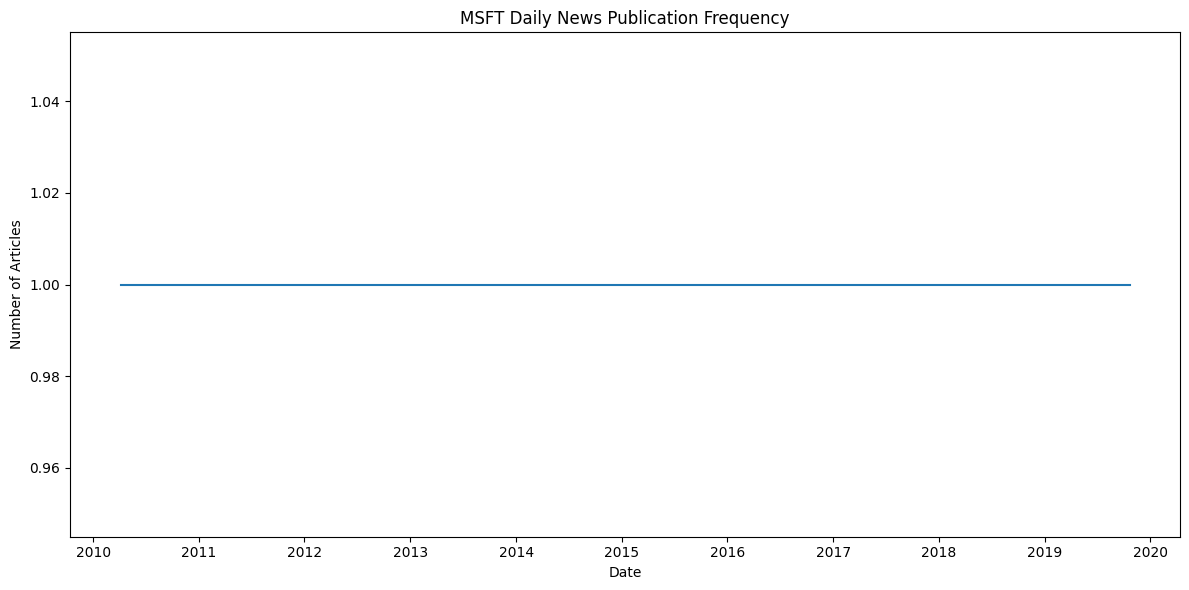


MSFT Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3604 entries, 2010-04-06 to 2024-07-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3604 non-null   float64
 1   High          3604 non-null   float64
 2   Low           3604 non-null   float64
 3   Close         3604 non-null   float64
 4   Adj Close     3604 non-null   float64
 5   Volume        3604 non-null   int64  
 6   Dividends     3604 non-null   float64
 7   Stock Splits  3604 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 253.4 KB
None


In [10]:
# ------------------ Visualize News Frequency ------------------
daily_counts = daily_article_counts(df_news_msft)
plot_daily_article_frequency(daily_counts, title=f'{ticker} Daily News Publication Frequency')

# ------------------ Load Stock Price Data ------------------
df_stock = pd.read_csv(stock_path)
df_news_msft.loc[:, 'date'] = pd.to_datetime(df_news_msft['date'], utc=True).dt.tz_localize(None)


df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)
df_stock = df_stock[df_stock.index >= df_news_msft['date'].min()]  # Align with news

print("\nMSFT Stock Data Info:")
print(df_stock.info())

In [11]:
# ------------------ Technical Indicators ------------------
df_stock['SMA_20'] = talib.SMA(df_stock['Close'], timeperiod=20)
df_stock['EMA_20'] = talib.EMA(df_stock['Close'], timeperiod=20)
df_stock['RSI'] = talib.RSI(df_stock['Close'], timeperiod=14)
df_stock['MACD'], df_stock['MACD_Signal'], df_stock['MACD_Hist'] = talib.MACD(
    df_stock['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)

In [12]:
# ------------------ Financial Metrics ------------------
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100
df_stock['Volatility'] = df_stock['Daily_Return'].rolling(window=20).std()


MSFT with Indicators and Metrics:
                 Close      SMA_20        RSI  Daily_Return      MACD  \
Date                                                                    
2024-07-24  428.899994  451.887498  36.980921     -3.585481 -0.684986   
2024-07-25  418.399994  450.199498  31.696381     -2.448123 -2.740453   
2024-07-26  425.269989  448.820497  37.944660      1.641968 -3.771598   
2024-07-29  426.730011  447.809497  39.217239      0.343316 -4.420024   
2024-07-30  422.920013  446.118997  37.080269     -0.892836 -5.181612   

            MACD_Signal  MACD_Hist  
Date                                
2024-07-24     3.013510  -3.698496  
2024-07-25     1.862718  -4.603171  
2024-07-26     0.735855  -4.507452  
2024-07-29    -0.295321  -4.124703  
2024-07-30    -1.272579  -3.909033  


/tmp/ipykernel_118019/989467659.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


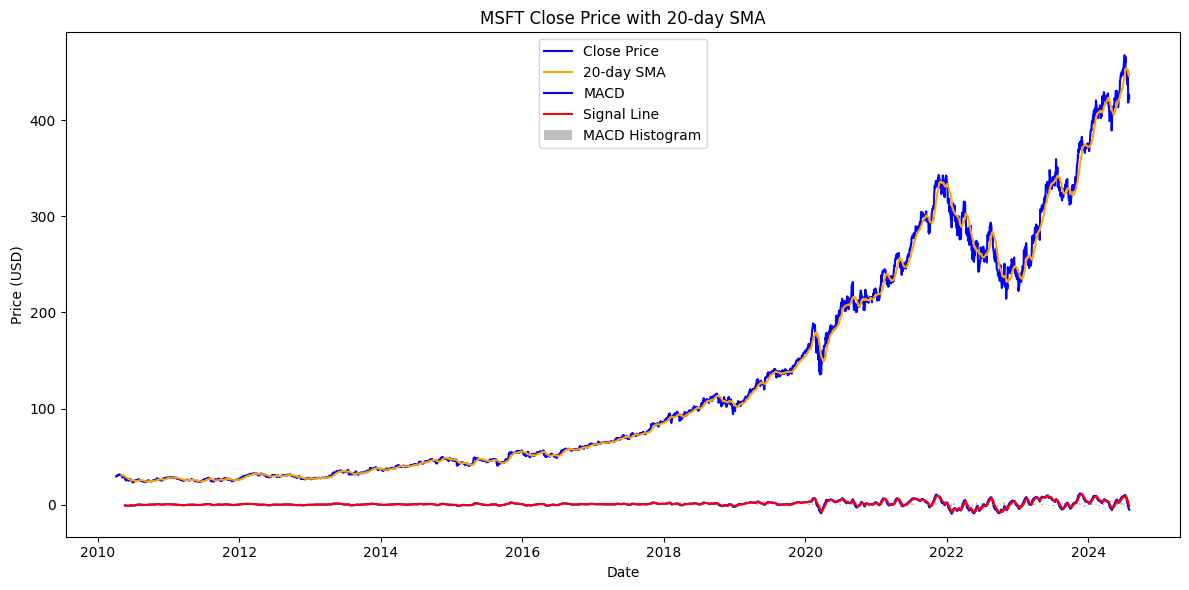

In [13]:
# ------------------ Inspect & Visualize ------------------
print("\nMSFT with Indicators and Metrics:")
print(df_stock[['Close', 'SMA_20', 'RSI', 'Daily_Return', 'MACD', 'MACD_Signal', 'MACD_Hist']].tail())


# Plot Close Price with SMA
plt.figure(figsize=(12, 6))
plt.plot(df_stock['Close'], label='Close Price', color='blue')
plt.plot(df_stock['SMA_20'], label='20-day SMA', color='orange')
plt.plot(df_stock.index, df_stock['MACD'], label='MACD', color='blue')
plt.plot(df_stock.index, df_stock['MACD_Signal'], label='Signal Line', color='red')
plt.bar(df_stock.index, df_stock['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)


plt.title(f'{ticker} Close Price with 20-day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()